In [1]:
from random import randint, randrange
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of sample points
N = 1024
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)

In [2]:
y = []
N_SIGNALS = 10
for i in range(N_SIGNALS):
    n_freq = randint(2,5)
    for j in range(n_freq+1):
        w = 2 * np.pi * randint(40, 400)
        if j == 0:
            s = randrange(0, 1) * np.sin(w*x)
        else:
            s += np.sin(w*x)
    y.append(s)

Wave: 0


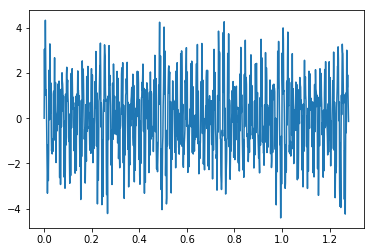

Wave: 1


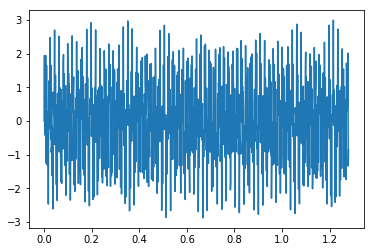

Wave: 2


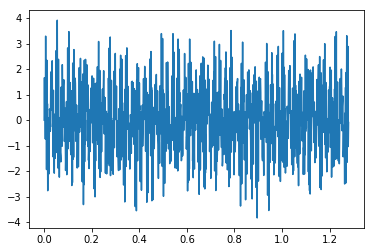

Wave: 3


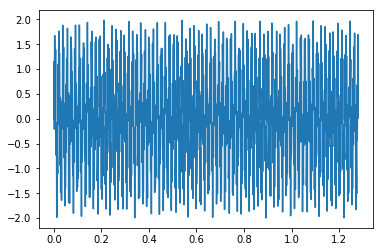

Wave: 4


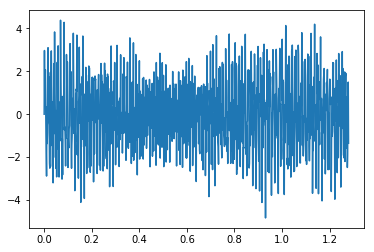

Wave: 5


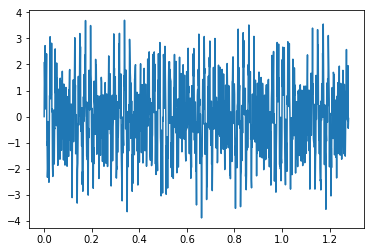

Wave: 6


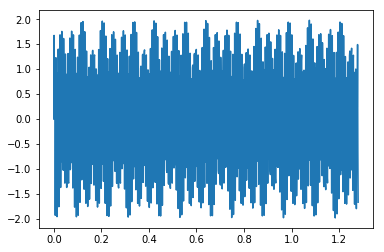

Wave: 7


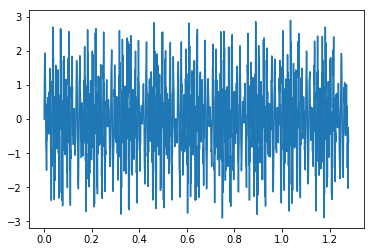

Wave: 8


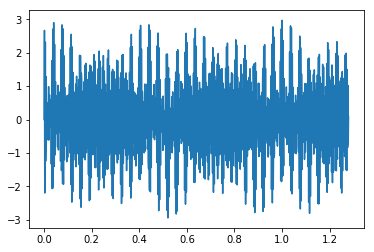

Wave: 9


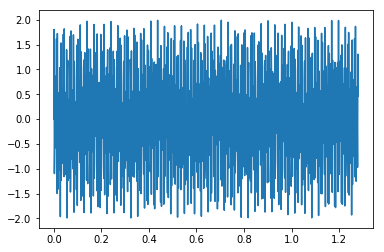

In [3]:
for i in range(N_SIGNALS):
    plt.figure()
    print(f"Wave: {i}")
    plt.plot(x,y[i])
    # Show/save figure as desired.
    plt.show()
    
# Can show all four figures at once by calling plt.show() here, outside the loop.
# plt.show()

In [4]:
import time

sw_output = []

for i in range(N_SIGNALS):
    yf = scipy.fftpack.fft(y[i])
    # yf.astype('complex64')
    sw_output.append(yf)
    
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


In [5]:
sw_output[0]

array([12.88046061+0.j        , 12.88340487+0.02425831j,
       12.89224708+0.04852029j, ..., 12.90701568-0.07278949j,
       12.89224708-0.04852029j, 12.88340487-0.02425831j])

Wave: 0


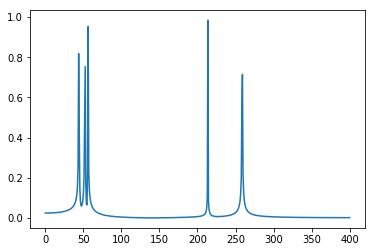

Wave: 1


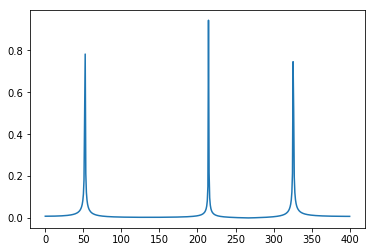

Wave: 2


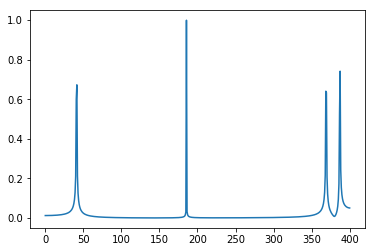

Wave: 3


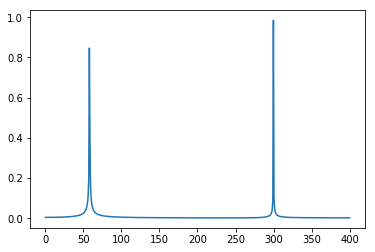

Wave: 4


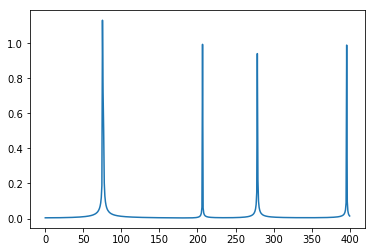

Wave: 5


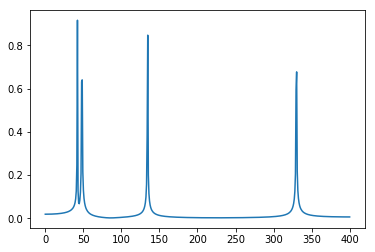

Wave: 6


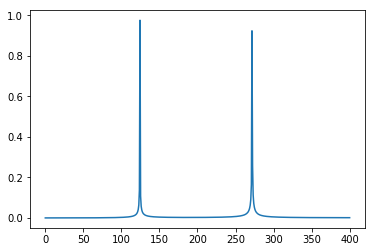

Wave: 7


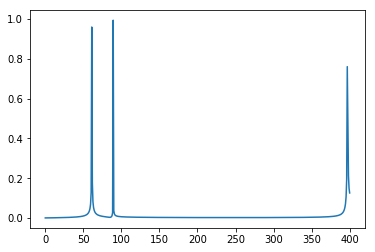

Wave: 8


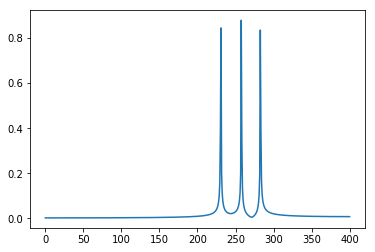

Wave: 9


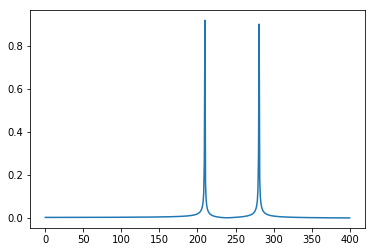

In [6]:
for i in range(N_SIGNALS):
    plt.figure()
    print(f"Wave: {i}")
    plt.plot(xf, 2.0/N * np.abs(sw_output[i][:N//2]))
    # Show/save figure as desired.
    plt.show()
    
# Can show all four figures at once by calling plt.show() here, outside the loop.
# plt.show()

In [7]:
from pynq import Overlay

overlay = Overlay(f"./1024_point_fft.bit")
# overlay?

In [8]:
import sys
import numpy as np
import pynq.lib.dma
from pynq import allocate
from random import randint
%matplotlib inline

fft_ip = overlay.fft_0

length = 1024
real_buffer = allocate(shape=(length,), dtype=np.float32)
img_buffer = allocate(shape=(length,), dtype=np.float32)

In [9]:
def zero_padding(unpadded_list):
    no_zeros = 1024-len(unpadded_list)
    padded_list = np.pad(unpadded_list, (0, no_zeros), 'constant', constant_values=(0,0))
    return padded_list

In [10]:
def ip(real_y, img_y):
    real_samples = real_y
    img_samples = img_y

    np.copyto(real_buffer, real_samples)
    np.copyto(img_buffer, img_samples)

    fft_ip.write(0x10, real_buffer.physical_address)
    fft_ip.write(0x18, img_buffer.physical_address)

    # running the IP
    fft_ip.write(0x00, 0x1)

    # wait until the ap_idle bit is 1
    while(fft_ip.read(0x00) & 0x4 == 0):
        pass

    real_output = np.array([0]*1024, dtype=np.float32)
    img_output = np.array([0]*1024, dtype=np.float32)
    
    np.copyto(real_output, real_buffer)
    np.copyto(img_output, img_buffer)

    ip_output = real_output + 1j*img_output
    return ip_output

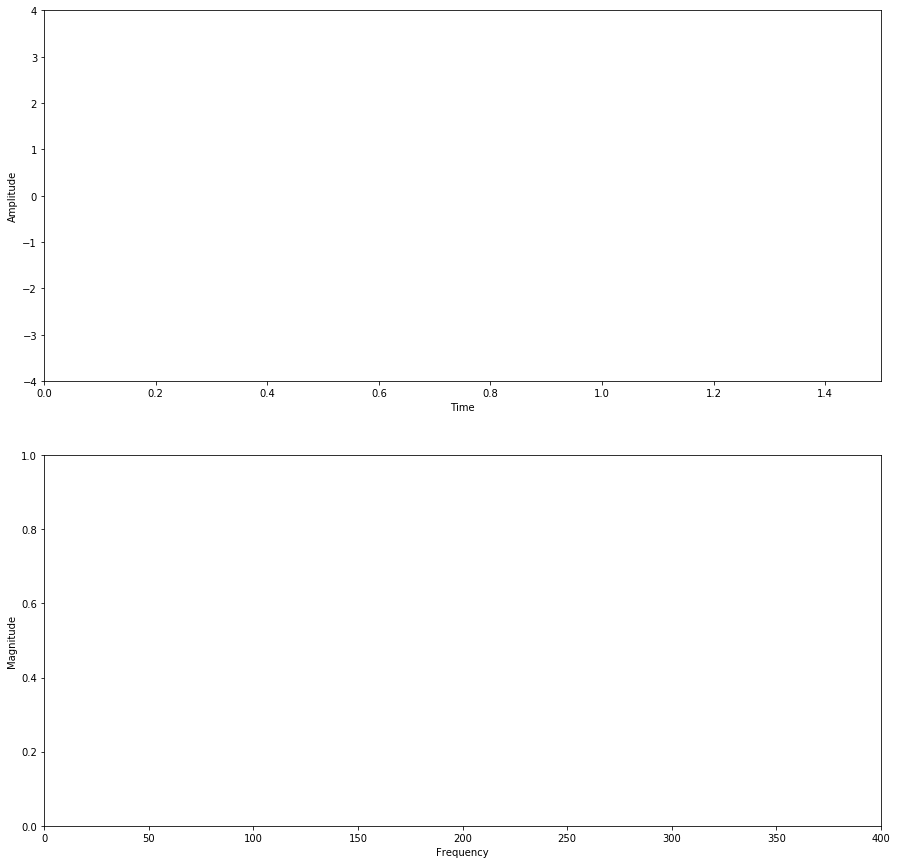

In [11]:
import sys
# create a figure and axis
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

# set up the subplot as needed
x_range_1 = 4
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.set_ylim((-1*x_range_1, x_range_1))
ax1.set_xlim((0, 1.5))

ax2.set_xlabel('Frequency')
ax2.set_ylabel('Magnitude')
ax2.set_xlim((0, 400))
ax2.set_ylim(( 0, 1))

# create the objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.

line1, = ax1.plot([], [], 'green', lw=2)
line2, = ax2.plot([], [], 'blue', lw=2)

# number of new points considered per frame
no_of_pts = 128

# number of frames in the animation
no_of_frames_per_wave = int(1024/no_of_pts)

In [15]:
# no of frames per wave = total points to be plotted / how many new points are being considered each frame (i.e. no_of_pts)
# no of frames = no of frames per wave * number of waves to be plotted
wave_input = [y[0],  y[1], y[3]+y[4], y[9]-y[5], y[8]]
def create_input(frame_num, wave_input):
    if frame_num >= no_of_frames_per_wave:      
        frame_input = []
        idx = frame_num // no_of_frames_per_wave
        offset = frame_num % no_of_frames_per_wave
        
        if offset*no_of_pts < 1024:
            frame_input = wave_input[idx-1][-(1024 - offset*no_of_pts):]
        try:
            frame_input = np.concatenate((frame_input, wave_input[idx][:offset*no_of_pts]))
        except:
            pass
            # print(f"{frame_num} {idx} {offset}")
        return frame_input

    else:
        # print(f"{frame_num}: {len(wave_input[0][:(frame_num+1)*no_of_pts])}")
        return wave_input[0][:(frame_num+1)*no_of_pts]

def drawframe(n):
    unpadded_list = create_input(n, wave_input)
    padded_list = zero_padding(unpadded_list)
    
    img_y = [0]*1024
    ip_output = ip(padded_list, img_y)
    
    # print the loading screen 
    loading_percentage = ((n+1) / (no_of_frames_per_wave*len(wave_input)+1)) * 100 if ((n+1) / (no_of_frames_per_wave*len(wave_input)+1)) * 100 < 100 else 100
    sys.stdout.write(f"Loading: {loading_percentage:.2f}%\r")
    sys.stdout.flush()
    
    line1.set_data(x, padded_list)
    line2.set_data(xf, 2.0/N * np.abs(ip_output[:N//2]))

    return [line1, line2]

In [16]:
from matplotlib import animation
from matplotlib import rc

# frame = total values that the argument n can take in function drawframe(n)
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=no_of_frames_per_wave*len(wave_input)+1, blit=True)

# install ffmpeg using sudo apt-get install ffmpeg
# find ffmpeg path using which ffmpeg
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [17]:
anim

Index: 0
Input


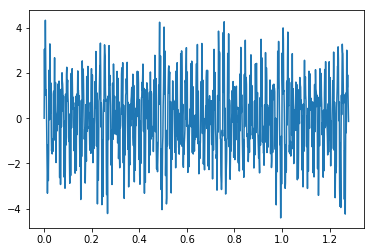

Software Output


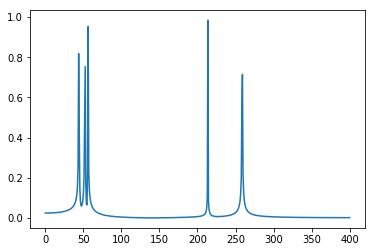

IP Output


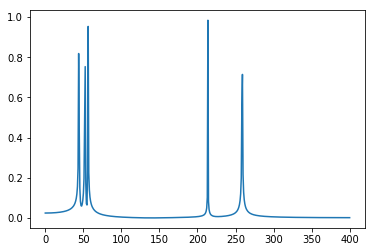

Index: 1
Input


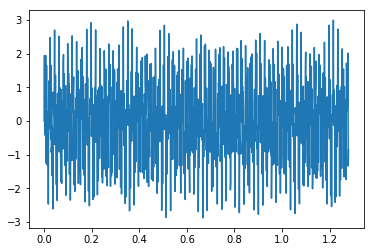

Software Output


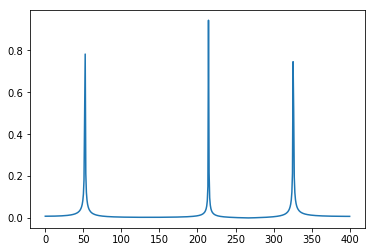

IP Output


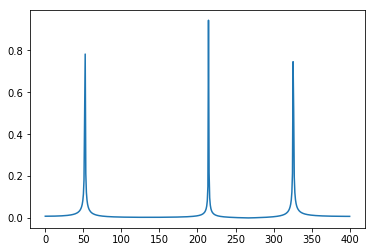

Index: 2
Input


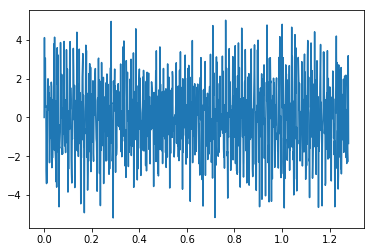

Software Output


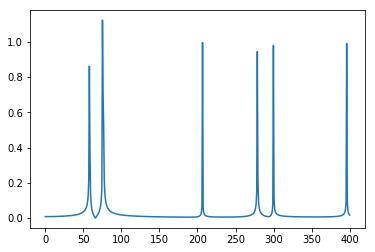

IP Output


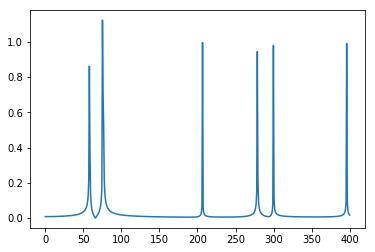

Index: 3
Input


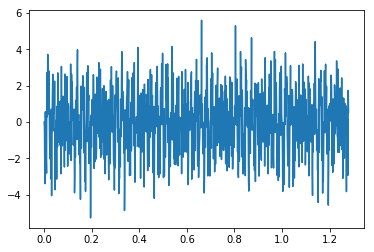

Software Output


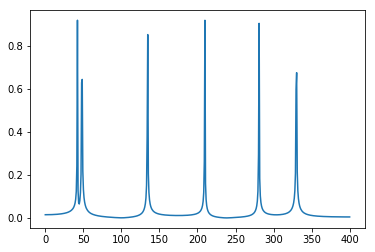

IP Output


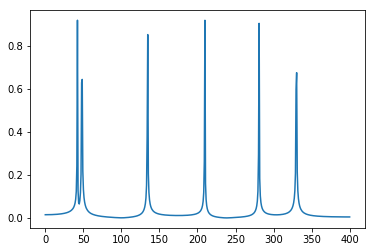

Index: 4
Input


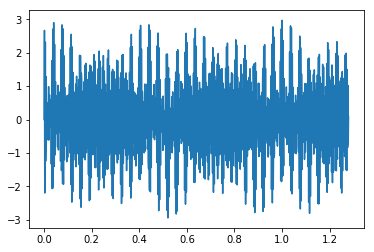

Software Output


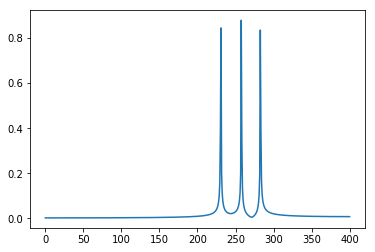

IP Output


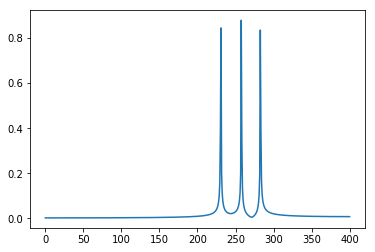

In [18]:
for idx, wi in enumerate(wave_input):    
    print(f"Index: {idx}")
    print("Input")
    plt.figure()
    plt.plot(x, wi)
    plt.show()

    # software output
    print("Software Output")
    plt.figure()
    sw_wave_output = scipy.fftpack.fft(wi)
    plt.plot(xf, 2.0/N * np.abs(sw_wave_output[:N//2]))
    plt.show()

    # ip output
    print("IP Output")
    plt.figure()

    unpadded_list = wi
    padded_list = zero_padding(unpadded_list)

    img_y = [0]*1024
    ip_wave_output = ip(padded_list, img_y)

    plt.plot(xf, 2.0/N * np.abs(ip_wave_output[:N//2]))
    plt.show()

In [19]:
# testing functions
ip_output = []
for i in range(N_SIGNALS):
    img_y = [0]*1024
    ip_output.append(ip(y[i], img_y))

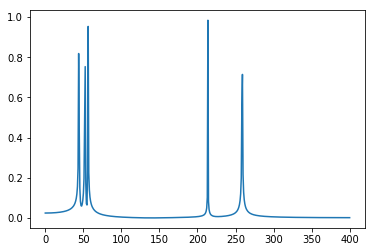

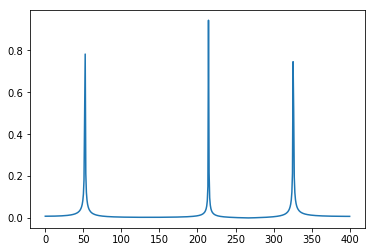

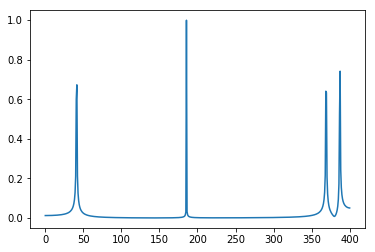

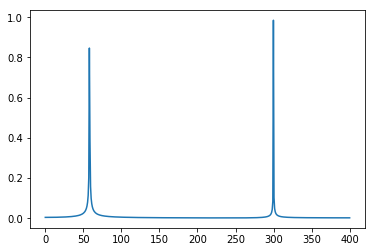

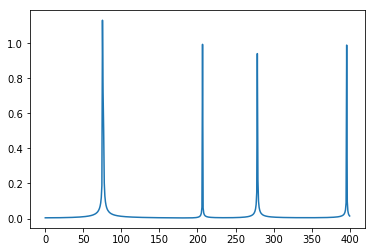

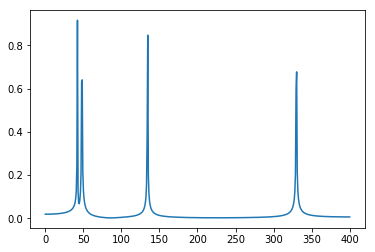

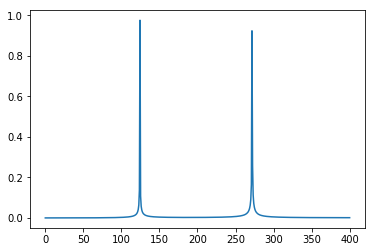

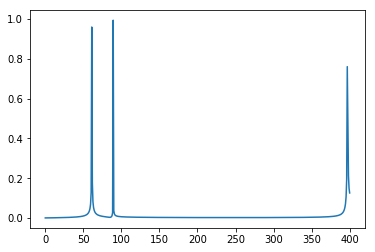

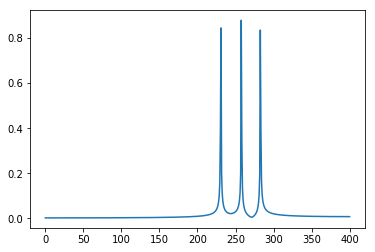

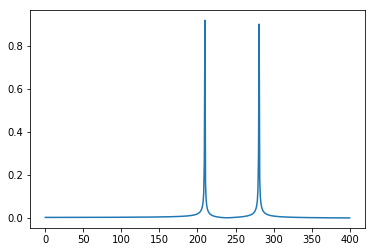

In [20]:
for i in range(N_SIGNALS):
    plt.figure()
    plt.plot(xf, 2.0/N * np.abs(ip_output[i][:N//2]))
    # Show/save figure as desired.
    # plt.show()
    
# Can show all four figures at once by calling plt.show() here, outside the loop.
plt.show()

In [21]:
threshold = [0.1, 0.01]

print("Signal \t 0.1% Error Margin \t 0.01% Error Margin")
for k in range(N_SIGNALS):
    for j in range(len(threshold)):
        error_count = [0, 0]
        for i in range(length):
            if y[k][i] != 0 + 0j:
                error_margin =  ( sw_output[k][i] - ip_output[k][i] ) / sw_output[k][i]
                error_margin = np.abs(error_margin)
            else:
                error_margin =  ( sw_output[k][i] - ip_output[k][i] ) / (0.001 + 0.001j)
                error_margin = np.abs(error_margin)
            if error_margin*100 > threshold[j]:
                    error_count[j] += 1
                # print(f"Error: {error_margin}")
                # print(f"{sw_output[k][i]} =/= {ip_output[k][i]}\n")
    print(f"{k} \t\t {error_count[0]} \t\t\t {error_count[1]}")

Signal 	 0.1% Error Margin 	 0.01% Error Margin
0 		 0 			 60
1 		 0 			 20
2 		 0 			 54
3 		 0 			 19
4 		 0 			 13
5 		 0 			 21
6 		 0 			 10
7 		 0 			 42
8 		 0 			 26
9 		 0 			 21
